# Impact of introducing hepatitis B vaccine into the mandatory vaccination schedule.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
import warnings; warnings.simplefilter('ignore')

## 2. Pre-Analysis

### 2.1 Visualizing yearly incidence of vaccine-preventable diseases over time

In [18]:
mask = ['hepatitis_B']
vaccine_pd = (pd.read_csv('../datasets/vaccine-preventable-diseases.csv')
                 .set_index('year', drop=True)
                 .loc[:, mask])

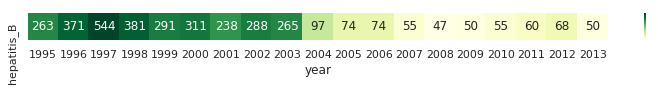

In [29]:
fig, ax = plt.subplots(1,1,figsize=(13,0.5))
sns.heatmap(np.log(vaccine_pd.T+0.1), robust=True, annot=vaccine_pd.T, fmt="d",
            cmap='YlGn', ax = ax, cbar_kws={'ticks':[]}); plt.show()

### 2.2 Visualizing yearly hepB vaccination numbers

In [32]:
mask = ['antihepatitis_B_peds', 'antihepatitis_B_adul', 'pentavalente']
vaccine_records = (pd.read_csv('../datasets/vaccination-records.csv')
                       .set_index('year', drop=True)
                       .loc[:, mask]
                       .assign(hepB_total = lambda x: x.sum(axis=1)))

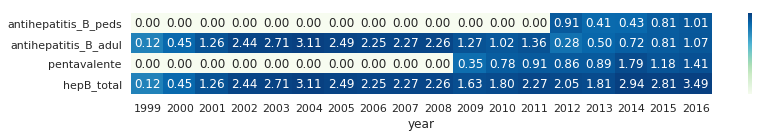

In [33]:
fig, ax = plt.subplots(1,1,figsize=(13,1.5))
sns.heatmap(np.log(vaccine_records.T+0.1), robust=True, annot=np.divide(vaccine_records.T,100_000),
            fmt=".2f", cmap='GnBu', ax = ax, cbar_kws={'ticks':[]}); plt.show()

### 2.3 Setting the DataFrame for analysis

In [108]:
data = (pd.DataFrame({'year': range(1995,2017)})
            .merge(vaccine_records['hepB_total'].reset_index(), on='year', how='left')
            .merge(vaccine_pd['hepatitis_B'].reset_index(), on='year', how='left')
            .assign(vaccines_sum = lambda x: x['hepB_total'].cumsum())
            .rename(columns={'hepB_total':'vaccines', 'hepatitis_B':'cases'})
            .set_index('year')
       )

## 3. Analysis

### 3.1 Regression analysis

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [62]:
glm_model = smf.glm('cases ~ I(vaccines_sum/100000)', 
                family=sm.families.Poisson(), 
                data = data).fit(cov_type='HC3')

In [48]:
print(str(glm_model.summary())[790:])

                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.8884      0.090     65.664      0.000       5.713       6.064
I(vaccines_sum / 100000)    -0.0929      0.009    -10.300      0.000      -0.111      -0.075


#### 3.1.1 Model interpretation

For every 100.000 people vaccinated, hepB cases decreases by 9% (IRR: 0.91, CI 0.89 - 0.92).

In [110]:
data = data.assign(glm_pred = lambda x: glm_model.predict(x.loc[range(1999,2014),'vaccines_sum']))

### 3.2 Interrupted time series

In [164]:
itt = (data.loc[range(1995,2014)]
           .assign(time = 1)
           .assign(time = lambda x: x['time'].cumsum(),
                   intervention = lambda x: x['time'].apply(lambda x: 1 if x > 9 else 0))
           .loc[:,['cases','time', 'intervention', 'vaccines_sum']])

In [150]:
itt_model = smf.glm('cases ~ time + intervention + time:intervention', 
                family=sm.families.Poisson(), 
                data = itt).fit(cov_type='HC3')

In [152]:
print(str(itt_model.summary())[790:])

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.0209      0.213     28.301      0.000       5.604       6.438
time                 -0.0470      0.030     -1.554      0.120      -0.106       0.012
intervention         -1.1432      0.358     -3.191      0.001      -1.845      -0.441
time:intervention    -0.0044      0.036     -0.121      0.904      -0.075       0.066


#### 3.2.1 Model interpretation

Following the introduction of hepatitis B vaccine into the mandatory vaccination schedule in 2003, new cases of hepatitis B in Buenos Aires' City diminished by 69% (IRR: 0.31, CI95: 0.15 - 0.64).

In [188]:
itt = (itt.assign(
    wo_intervention = lambda x: itt_model.predict(pd.DataFrame({'time':x['time'],'intervention':0})),
    w_intervention = lambda x: itt_model.predict(pd.DataFrame({'time':x['time'],'intervention':1}))))

## 4. Figures

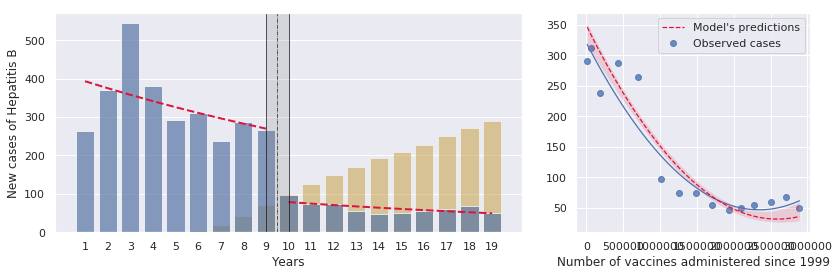

In [223]:
fig, (axa, axb) = plt.subplots(1,2,figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})

sns.regplot(data.loc[range(1999,2014), 'vaccines_sum'], data.loc[range(1999,2014), 'cases'],
           order=2, truncate=True, ci=False, label='Observed cases', ax=axb) 
sns.regplot(data.loc[range(1999,2014), 'vaccines_sum'], data.loc[range(1999,2014), 'glm_pred'],
           order=2, truncate=True, scatter=False, color='crimson', label="Model's predictions", ax=axb)

axb.lines[1].set_linestyle("--"); axb.lines[0].set_linewidth(1.25); axb.lines[1].set_linewidth(1.25)
axb.set_ylabel(''); axb.set_xlabel('Number of vaccines administered since 1999')
axb.legend()


sns.barplot(itt['time'], np.divide(itt['vaccines_sum'],10000), color = 'goldenrod', alpha = 0.5, ax = axa)
sns.barplot('time', 'cases', color = 'b', alpha = 0.7, data = itt, ax = axa)
sns.lineplot(range(0,9), itt.loc[range(1995,2004),'wo_intervention'], color = 'crimson', ax = axa)
sns.lineplot(range(9,19), itt.loc[range(2004,2014),'w_intervention'], color = 'crimson', ax = axa)

axa.lines[38].set_linestyle("--"); axa.lines[39].set_linestyle("--")
axa.lines[38].set_linewidth(2); axa.lines[39].set_linewidth(2)

axa.set_ylabel('New cases of Hepatitis B'); axa.set_xlabel('Years'); 

axa.axvline(8.5, c='black', lw=0.6, ls='-.')
axa.axvline(8, c='black', lw=0.6);axa.axvline(9, c='black', lw=0.6)
axa.axvspan(8, 9, alpha=0.2, color='grey')

plt.tight_layout()
plt.show()